In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re

from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D, Input, MaxPooling1D, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from sklearn.model_selection import train_test_split
import requests
%load_ext tensorboard
print(tf.__version__)

2.5.0


# Download the data
First, we load the data. This are two classes. Every class has it's own file. Our task it to discern clickbait titles from non-clickbait

In [2]:
datadir = '../data'
files = !ls $datadir
files

['cancer_data.csv',
 'cancer_data_uncleaned.csv',
 'clickbait_data.txt',
 'dataset1.csv',
 'dataset2.csv',
 'non_clickbait_data.txt',
 'rotten_tomatoes_movies.csv']

In [3]:
getfiles = ['clickbait_data.txt', 'non_clickbait_data.txt']
if 'clickbait_data.txt' not in files:
    for file in getfiles:
        url = "https://raw.githubusercontent.com/SnehilVerma/Clickbait-Detection/master/{}".format(file)
        req = requests.get(url)
        url_content = req.content
        path = os.path.join(os.path.expanduser(datadir), file)
        csv_file = open(path, 'wb')
        csv_file.write(url_content)
        csv_file.close()

Now, we load in the data, and prepare the labels.

In [4]:
file1 = os.path.join(os.path.expanduser(datadir), 'clickbait_data.txt')
click = pd.read_csv(file1, header=None, delimiter='\n', names=['text'])
click['label'] = 1

file2 = os.path.join(os.path.expanduser(datadir), 'non_clickbait_data.txt')
noclick = pd.read_csv(file2, header=None, delimiter='\n',  names=['text'])
noclick['label'] = 0

data = pd.concat([click, noclick], ignore_index=True)

SIZE = len(data)
BATCH = 32
SIZE

32000

In [6]:
data

,text,label
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1
...,...,...
31995,"To Make Female Hearts Flutter in Iraq, Throw a...",0
31996,"British Liberal Democrat Patsy Calton, 56, die...",0
31997,Drone smartphone app to help heart attack vict...,0
31998,"Netanyahu Urges Pope Benedict, in Israel, to D...",0


Create a `tf.data.Dataset`. You can feed it the `text` and `label` columns as a single tuple, eg `(data['text'], data['label'])`. After that, shuffle the dataset with `buffer_size=SIZE` and make batch the dataset.

In [7]:
ds = tf.data.Dataset.from_tensor_slices((data["text"], data['label']))
ds = ds.shuffle(buffer_size=SIZE).batch(BATCH)

Let's have a look at the first batch.
Check one batch visually with `take(1)`.

In [8]:
for x, y in ds.take(1):
  print(x)
  print(y)
  print(x.shape)
  print(y.shape)

tf.Tensor(
[b'Sinkhole reported in Buffalo, New York'
 b'Sturm und Drang About Pint-Size Neighbors'
 b"23 Times Justin Bieber's Instagram Awakened Your Inner Thirst"
 b'23 Things Teachers Actually Want For Christmas'
 b'These People Go On A Bar Crawl To Find The Best Nachos In LA'
 b'13 Lies Your Depression Is Telling You'
 b'Music promoter Mean Fiddler sold for almost \xc2\xa338m'
 b'21 Times Angie Was The Best Part Of "30 Rock"'
 b'Canada to revisit same-sex marriage issue next week'
 b'People Met Pet Rats For The First Time And Lost Their Damn Minds'
 b'This Is What Your $10 Ikea Lack Table Looks Like Inside'
 b'What 10 World Landmarks Could Look Like In An Epic Drought'
 b'Which Member Of 5 Seconds Of Summer Are You'
 b'Reading the Brains of Pigeons in Flight'
 b"New Yorker's Obama cover sparks outrage"
 b'Can You Identify These Meryl Streep Movies By Their Amazon Reviews'
 b'15 Things That Happen When People Think You Don\'t "Look Latina"'
 b'32 Of The Greatest Things That Happene

So, we see a lot of titles, some are clickbait, and some are not. The labels are integers 1 or 0.

Now, create a train-valid-test split.

Create a train and test set with a 80% split. Remember that your dataset is batched, so you should use `SIZE/BATCH` as the total amount of items.

Use `.take()` and `.skip()` to take the first n observations, and then skip the first n observations to create your sets.

In [9]:
train_n = int(SIZE/BATCH * 0.8)
test_n = int(SIZE/BATCH * 0.1)
train_ds = ds.take(train_n)
valtest = ds.skip(train_n)
val_ds = valtest.take(test_n)
test_ds = valtest.skip(test_n)
len(train_ds), len(val_ds), len(test_ds)

(800, 100, 100)

Use `.prefetch()` with `tf.data.experimental.AUTOTUNE` to prefetch the data. This speeds up performance.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Clean and preprocess the data
We can preprocess the text. First, it would make sense to change everything to lowercase with `tf.strings.lower`, and the to replace the punctuation with `tf.strings.regex_replace`

In [11]:
punctuation = '[%s]' % string.punctuation

def custom_standardization(input_data):
  x = tf.strings.lower(input_data) # all tekst to lowercase
  x = tf.strings.regex_replace(x, punctuation, '')
  return x

custom_standardization(x)

<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'sinkhole reported in buffalo new york',
       b'sturm und drang about pintsize neighbors',
       b'23 times justin biebers instagram awakened your inner thirst',
       b'23 things teachers actually want for christmas',
       b'these people go on a bar crawl to find the best nachos in la',
       b'13 lies your depression is telling you',
       b'music promoter mean fiddler sold for almost \xc2\xa338m',
       b'21 times angie was the best part of 30 rock',
       b'canada to revisit samesex marriage issue next week',
       b'people met pet rats for the first time and lost their damn minds',
       b'this is what your 10 ikea lack table looks like inside',
       b'what 10 world landmarks could look like in an epic drought',
       b'which member of 5 seconds of summer are you',
       b'reading the brains of pigeons in flight',
       b'new yorkers obama cover sparks outrage',
       b'can you identify these meryl streep movi

Creater a `TextVectorization` layer. Pick a `vocab_size` and `sequence_length`, and add your `custom_standardization`.

In [12]:
%%time
# Pick a vocabulary size and number of words in a sequence.
vocab_size = 5000
sequence_length = 20

# Use the text vectorization layer to normalize, split, and map strings to 
# integers. Note that the layer uses the custom standardization defined above. 
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

#text_ds = train_ds.map(lambda x, y: x)
text_ds = train_ds.map(tf.autograph.experimental.do_not_convert(lambda x, y: x))
vectorize_layer.adapt(text_ds)

CPU times: user 755 ms, sys: 77.1 ms, total: 832 ms
Wall time: 493 ms


Build a model with the following architecture:

- an input layer with `shape=[1]` and `dtype=tf.string`
- your vectorize_layer
- an `Embedding` layer. Set the embedding to 100.
- `GlobalAveragePooling1D`
- one `Dense` layer, with 64 units and `relu`
- a final `Dense` layer with one unit and a `sigmoid`

In [13]:
from tensorflow.keras.layers import Conv1D, Dropout, GlobalMaxPooling1D
model = Sequential([
    InputLayer(input_shape=[1], dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, 100),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

Compile it with Adam and a $10^{-4}$ learningrate, with binary_crossentropy as loss. Try to figure out how to add precision and recall to the metrics.
Train for 3 epochs.

In [14]:
from tensorflow.keras.metrics import Precision, Recall

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])


model.fit(train_ds, epochs=3, validation_data=val_ds, verbose=1)

Epoch 1/3
800/800 [==============================] - 3s 3ms/step - loss: 0.5764 - accuracy: 0.8808 - precision: 0.8515 - recall: 0.9230 - val_loss: 0.3427 - val_accuracy: 0.9422 - val_precision: 0.9613 - val_recall: 0.9190
Epoch 2/3
800/800 [==============================] - 2s 3ms/step - loss: 0.2064 - accuracy: 0.9509 - precision: 0.9614 - recall: 0.9394 - val_loss: 0.1297 - val_accuracy: 0.9631 - val_precision: 0.9683 - val_recall: 0.9559
Epoch 3/3
800/800 [==============================] - 3s 3ms/step - loss: 0.1068 - accuracy: 0.9671 - precision: 0.9711 - recall: 0.9630 - val_loss: 0.0869 - val_accuracy: 0.9722 - val_precision: 0.9719 - val_recall: 0.9725


In [15]:
model.evaluate(test_ds)

100/100 [==============================] - 0s 2ms/step - loss: 0.0881 - accuracy: 0.9744 - precision: 0.9720 - recall: 0.9769


[0.08805856108665466,
 0.9743750095367432,
 0.9720149040222168,
 0.9768750071525574]

# Rotten Tomatoes
Now, let's try something a bit more complex.

We download the data, if it is not present

In [16]:
datadir = '../data'
files = !ls $datadir
files

['cancer_data.csv',
 'cancer_data_uncleaned.csv',
 'clickbait_data.txt',
 'dataset1.csv',
 'dataset2.csv',
 'non_clickbait_data.txt',
 'rotten_tomatoes_movies.csv']

In [17]:
file = 'rotten_tomatoes_movies.csv'
if file not in files:
    url = "https://raw.githubusercontent.com/raoulg/tmoi-ml-20/master/data/rotten_tomatoes_movies.csv"
    req = requests.get(url)
    url_content = req.content
    path = os.path.join(os.path.expanduser(datadir), file)
    csv_file = open(path, 'wb')
    csv_file.write(url_content)
    csv_file.close()

And load it to memory

In [18]:
path = os.path.join(os.path.expanduser(datadir), file)
data = pd.read_csv(path)
df = data[['movie_info', 'genres']]
df = df.dropna()
df.head(3)

,movie_info,genres
0,"Always trouble-prone, the life of teenager Per...","Action & Adventure, Comedy, Drama, Science Fic..."
1,Kate (Catherine Keener) and her husband Alex (...,Comedy
2,"A successful, middle-aged Hollywood songwriter...","Comedy, Romance"


We have a description of the movie as unstructured text and a set of labels.

Let's check how many different genres we have. Interesting enough, this is a multilabel dataset, meaning that every move can belong to multiple labels at once.

In [19]:
flatten = lambda t: [item for sublist in t for item in sublist]
set(flatten([txt.split(", ") for txt in df.genres.values]))

{'Action & Adventure',
 'Animation',
 'Anime & Manga',
 'Art House & International',
 'Classics',
 'Comedy',
 'Cult Movies',
 'Documentary',
 'Drama',
 'Faith & Spirituality',
 'Gay & Lesbian',
 'Horror',
 'Kids & Family',
 'Musical & Performing Arts',
 'Mystery & Suspense',
 'Romance',
 'Science Fiction & Fantasy',
 'Special Interest',
 'Sports & Fitness',
 'Television',
 'Western'}

That might be a bit too much. Let's start out with just a subset of the labels. We can always increase the amount of labels to learn.

In [20]:
import re
df['select'] = df.genres.apply(lambda x: re.findall('Science Fiction|Romance|Comedy|Action|Art', x))

It can be usefull to create a one-hot encoding. This way, we can generate a model with as a final layer as much units as we have classes. 

Another option could be to use a "sparse" loss function, but let's just try this out.

In [21]:
from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
X = df['movie_info']
y = mlb.fit_transform(df['select'])
y.shape

(17372, 5)

In [22]:
y

array([[1, 0, 1, 0, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 1, 0],
       ...,
       [1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [1, 1, 0, 0, 0]])

In [23]:
df.head()

,movie_info,genres,select
0,"Always trouble-prone, the life of teenager Per...","Action & Adventure, Comedy, Drama, Science Fic...","[Action, Comedy, Science Fiction]"
1,Kate (Catherine Keener) and her husband Alex (...,Comedy,[Comedy]
2,"A successful, middle-aged Hollywood songwriter...","Comedy, Romance","[Comedy, Romance]"
3,Following the closing arguments in a murder tr...,"Classics, Drama",[]
4,"In 1866, Professor Pierre M. Aronnax (Paul Luk...","Action & Adventure, Drama, Kids & Family",[Action]


Now, we want to get rid of every observation that has zero labels.

In [24]:
keep = np.sum(y, axis=1) != 0
X = X[keep]
y = y[keep]
len(X), len(y)

(11368, 11368)

In [25]:
y, X.shape, y.shape

(array([[1, 0, 1, 0, 1],
        [0, 0, 1, 0, 0],
        [0, 0, 1, 1, 0],
        ...,
        [1, 0, 1, 0, 0],
        [1, 1, 0, 0, 0],
        [1, 1, 0, 0, 0]]),
 (11368,),
 (11368, 5))

In [26]:
SIZE = len(X)
BATCH = 32
SIZE

11368

So, we lost about 6000 movies, but we still have enough to make a model. If you want to experiment, you can add more categories and see if you can still get good results. But first, let us visualize the distribution of the labels.

<BarContainer object of 5 artists>

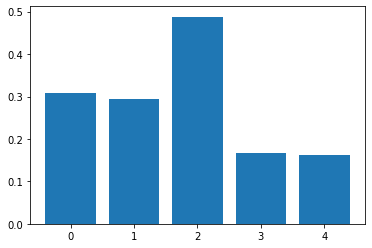

In [27]:
import matplotlib.pyplot as plt

distribution = np.mean(y, axis=0)
plt.bar(range(len(distribution)), distribution)

In [28]:
CLASSES = y.shape[1]
CLASSES

5

Same as before:
- generate datasets from tensor slices
- shuffle and batch
- pick a train-test ratio
- create sets with `take` and `skip`
- prefetch with AUTOTUNE

In [29]:
ds = tf.data.Dataset.from_tensor_slices((X, y))
ds = ds.shuffle(buffer_size=SIZE).batch(BATCH)

train_n = int(SIZE/BATCH * 0.8)
test_n = int(SIZE/BATCH * 0.1)

train_ds = ds.take(train_n)
testvalid = ds.skip(train_n)
test_ds = testvalid.take(test_n)
val_ds = testvalid.skip(test_n)

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

len(train_ds), len(val_ds), len(test_ds)

(284, 37, 35)

Let's peak at the first batch:

In [30]:
for x, y in train_ds.take(1):
  print(x)
  print(y)

tf.Tensor(
[b'Commuting to Manhattan on the same train, two married strangers (Robert De Niro, Meryl Streep) meet by accident and have an affair.'
 b'Each week Kable (Gerard Butler), a death-row inmate, battles his fellow prisoners in a violent online game called "Slayers," his every move controlled by a young gamer\'s remote device. To the players, Kable and the other inmates are just simulated characters. But, to a resistance group that opposes the game\'s inventor, Kable is a critical component of their plan to end the inventor\'s form of high-tech slavery.'
 b"Katie Feldman (Julianne Hough) moves to a small town on the North Carolina coast, determined to make a new life for herself. She takes a job as a waitress and keeps a low profile, but she is soon won over by the warmth and caring of the close-knit community, especially that of widower Alex (Josh Duhamel). With the help of Alex and his children, Katie learns to love and trust again -- but when a mysterious stranger arrives and

So, we have a long review of a move, and multiple genres.

First we set up a `TextVectorization` layer. Pick a sensible size for the `max_tokens` and `output_sequence_length`. If you are unsure of a proper size, test the impact of different sizes.

In [31]:
vocab_size = 10000
sequence_length = 50

# Use the text vectorization layer to normalize, split, and map strings to 
# integers. Note that the layer uses the custom standardization defined above. 
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length,
    name='vectorization_layer')


text_ds = train_ds.map(lambda x, y: x)
vectorize_layer.adapt(text_ds)

Make a model that has:
- InputLayer
- vectorizelayer
- Embedding of dim 50
- GlobalAveragePooling1D
- Dense with 64 units and a relu
- Dense with amount of classes. Don't use and activation in the last layer.

In [32]:
model = Sequential([
    InputLayer(input_shape=[1], dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, 50),
    GlobalAveragePooling1D(),
    Dense(64, activation='relu'),
    Dense(CLASSES)
])

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vectorization_layer (TextVec (None, 50)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 50, 50)            500000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                3264      
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 325       
Total params: 503,589
Trainable params: 503,589
Non-trainable params: 0
_________________________________________________________________


Because we didn't use an activation in the last layer, we got "logits" that range from $[-\infty, +\infty]$ instead of values between $[0,1]$ as we would have gotten with a sigmoid activation. Because of this, we have to tell the loss function we need `from_logits` to be `True`.

Try to increase and decrease the predictions by modifying the numbers below. First, decide if you want to get the loss up  or down. Then, modify the prediction. Check if you understand whats happening.

In [34]:
y_true = [[1, 0, 1], [0, 0, 1]]
y_pred = [[5.0, -10.0, 5], [-5.0, -10, 20]]
loss = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True)
loss.numpy()

array([0.00449203, 0.00225358], dtype=float32)

Compile the function with Adam and binary_crossentropy with logits.

In [35]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

Train for 20 epochs.

In [36]:
logdir = os.path.join("logs", "emb50_dense64")
tb = TensorBoard(logdir, histogram_freq=0)

model.fit(
    train_ds,
    validation_data=val_ds, 
    epochs=20,
    callbacks=[tb])

Epoch 1/20
284/284 [==============================] - 2s 4ms/step - loss: 0.5784 - accuracy: 0.3341 - val_loss: 0.5475 - val_accuracy: 0.3698
Epoch 2/20
284/284 [==============================] - 1s 5ms/step - loss: 0.5176 - accuracy: 0.4364 - val_loss: 0.4564 - val_accuracy: 0.5560
Epoch 3/20
284/284 [==============================] - 1s 5ms/step - loss: 0.4342 - accuracy: 0.6038 - val_loss: 0.3901 - val_accuracy: 0.6621
Epoch 4/20
284/284 [==============================] - 1s 5ms/step - loss: 0.3771 - accuracy: 0.6708 - val_loss: 0.3330 - val_accuracy: 0.7026
Epoch 5/20
284/284 [==============================] - 1s 5ms/step - loss: 0.3290 - accuracy: 0.6992 - val_loss: 0.2919 - val_accuracy: 0.7362
Epoch 6/20
284/284 [==============================] - 1s 4ms/step - loss: 0.2887 - accuracy: 0.7245 - val_loss: 0.2455 - val_accuracy: 0.7595
Epoch 7/20
284/284 [==============================] - 1s 5ms/step - loss: 0.2568 - accuracy: 0.7391 - val_loss: 0.2068 - val_accuracy: 0.7871
Epoch 

In [37]:
for text, label in val_ds.take(1):
    print(text[:2])

tf.Tensor(
[b"For two years, security guard Ben (Kevin Hart) has tried to convince James (Ice Cube), a veteran cop, that he is worthy of James' sister, Angela. When Ben is finally accepted into the police academy, James decides to test his mettle by inviting him along on a shift deliberately designed to scare the trainee. However, events take an unexpected turn when their wild night leads to Atlanta's most-notorious criminal and Ben's rapid-fire mouth proves as dangerous as the bullets whizzing by them."
 b'Seven-year-old cousins Emmeline (Elva Josephson) and Richard (Glenn Kohan) survive a shipwreck and find themselves marooned on a beautiful island somewhere in the Pacific Ocean. Under the tutelage of a fellow castaway, Paddy Button (Leo McKern), the two learn the basics of survival. When Paddy dies, however, the now adolescent Emmeline (Brooke Shields) and Richard (Christopher Atkins) are on their own to discover sex, love and loneliness in a tropical paradise.'], shape=(2,), dtype=

Let's check the model. We grab the first two texts from our validation dataset.

Use the model to predict.

In [38]:
model.predict(text[:2])

array([[  3.2538111, -27.1035   ,  15.773536 ,  -9.315605 , -13.173566 ],
       [  9.481662 ,  -4.579263 , -11.013162 , -14.259049 ,  -5.070095 ]],
      dtype=float32)

Check the original label

In [39]:
label[:2]

<tf.Tensor: shape=(2, 5), dtype=int64, numpy=
array([[1, 0, 1, 0, 0],
       [1, 0, 0, 0, 0]])>

In [40]:
mlb.inverse_transform(label[:2].numpy())

[('Action', 'Comedy'), ('Action',)]

To check for ourselves, we can use `inverse_tranform` from the `mlb`. It is interesting how to model actually adds something to the original binary labels. While both examples migth predict correctly a movie to be comedy, the model tells us that it is much more clear from the text that the second one is a comedy (eg with values of 4 versus 12). Also, for a single movie, it can tell you which labels seems to be more likely or dominant. Try for yourself some more examples.

Now, create an architecture with a RNN. use the following:
- an `Input` layer
- your `vectorize_layer`
- an `Embedding` layer
- a type of RNN. Try `GRU` first, with 16 units.
- A final `Dense` layer, without an activation

In [42]:
from tensorflow.keras.layers import LSTM, GRU

model = Sequential([
    InputLayer(input_shape = [1], dtype=tf.string),
    vectorize_layer,
    Embedding(vocab_size, 50),
    GRU(16),
    Dense(CLASSES)
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vectorization_layer (TextVec (None, 50)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 50, 50)            500000    
_________________________________________________________________
gru_1 (GRU)                  (None, 16)                3264      
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 85        
Total params: 503,349
Trainable params: 503,349
Non-trainable params: 0
_________________________________________________________________


In [44]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [45]:
logdir = os.path.join("logs", "emb50_GRU")
tb = TensorBoard(logdir, histogram_freq=0)
model.fit(train_ds,
          epochs=20,
          validation_data=val_ds,
          verbose=1,
          callbacks=[tb])

Epoch 1/20
284/284 [==============================] - 9s 25ms/step - loss: 0.5776 - accuracy: 0.3326 - val_loss: 0.5577 - val_accuracy: 0.3534
Epoch 2/20
284/284 [==============================] - 6s 21ms/step - loss: 0.5493 - accuracy: 0.3434 - val_loss: 0.5373 - val_accuracy: 0.3362
Epoch 3/20
284/284 [==============================] - 5s 19ms/step - loss: 0.5104 - accuracy: 0.4198 - val_loss: 0.4474 - val_accuracy: 0.5112
Epoch 4/20
284/284 [==============================] - 5s 18ms/step - loss: 0.4404 - accuracy: 0.5393 - val_loss: 0.3865 - val_accuracy: 0.6172
Epoch 5/20
284/284 [==============================] - 5s 19ms/step - loss: 0.3916 - accuracy: 0.6001 - val_loss: 0.3594 - val_accuracy: 0.6414
Epoch 6/20
284/284 [==============================] - 5s 19ms/step - loss: 0.3541 - accuracy: 0.6455 - val_loss: 0.3246 - val_accuracy: 0.6526
Epoch 7/20
284/284 [==============================] - 6s 20ms/step - loss: 0.3160 - accuracy: 0.6781 - val_loss: 0.2929 - val_accuracy: 0.6853